#Initial Installs

In [ ]:
%%time
!pip install -q condacolab
import condacolab
condacolab.install()
!conda --version
!conda install ffmpeg=4.3 -c conda-forge
!conda install mlflow
!pip install pyngrok --quiet
!pip install audiomentations

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...


# Initial Imports, Mount Drive


In [1]:
# Initial imports
import numpy as np
import os
import pandas as pd
# needed to install torch like so:
#         pip3 install torch torchvision torchaudio
import tensorflow as tf # this needs to happen before any torch imports....
import torchaudio
import os

import librosa
import matplotlib.pyplot as plt
#import requests
from IPython.display import Audio, display
from google.colab import drive

from collections import Counter
from torch.utils.data import Dataset
from tqdm import tqdm
import random
import keras 
import mlflow
import mlflow.keras
import datetime

# Mount Drive
drive.mount('/content/gdrive')

archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  


Mounted at /content/gdrive


# Define Dataset Classes and Helper Functions

In [22]:
############
# Define a dataset class
#
# this should have methods for:
# loading
# preprocessing
# filtering
# train / test / validation splitting
###########

import torch


# define global variagbles
samples_per_batch = 32
spectrogram_max_length = 7336
number_of_mels = 128
random_seed_number = 108

random.seed(random_seed_number)

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    import numpy as np
    if not isinstance(waveform,np.ndarray):
      waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=1024,
    win_length=None,
    hop_length=512,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=128,
    mel_scale="htk",
)

class AccentDataset(Dataset):
    def __init__(self, audio_files_folder, metadata_file, make_spectra=False, language_samples_threshold = 30):
        self.audio_files_folder = audio_files_folder
        self.metadata_file = metadata_file
        self.make_spectra = make_spectra
        self.metadata = self.load_metadata()
        self.language_samples_threshold = language_samples_threshold
        self.metadata = self.filter_metadata()
        self.audio = self.load_audio()
        if not make_spectra:
            self.load_spectrograms()
        self.training_fraction = 0.67
        self.downsample_training = True
        self.downsampled_number = 5
        self.train_indices, self.test_indices = self.create_train_test_split()
        
    def load_metadata(self):
        metadata = pd.read_csv(self.metadata_file)
        return metadata
    
    def filter_metadata(self):
        self.metadata = self.metadata[self.metadata['file_missing?'] != True]
        samples_per_language = Counter(self.metadata['native_language'])    
        filtered_languages = [language for language in samples_per_language.keys() if \
                              samples_per_language[language] >= self.language_samples_threshold]
        filtered_speakers = self.metadata[self.metadata['native_language'].isin(filtered_languages)]
        return filtered_speakers
    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            if self.make_spectra:
                audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def write_spectrograms(self):
        print("Writing Spectrograms to Disk")
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name)
            np.save(spectrogram_file_full_path, self.audio[file_name].spectrogram)

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)
    
    def create_train_test_split(self):
        unique_languages = list(set(self.metadata['native_language']))
        train_indices =[]
        test_indices = []
        for language in unique_languages:
            this_language = self.metadata[self.metadata['native_language'] == language]
            this_language_male = this_language[this_language['sex']=='male']
            this_language_female = this_language[this_language['sex']=='female']
            traininds_male = random.sample(list(this_language_male.index), 
                                           int(self.training_fraction * len(this_language_male.index)))
            traininds_female = random.sample(list(this_language_female.index), 
                                           int(self.training_fraction * len(this_language_female.index)))
            traininds = traininds_male + traininds_female
            testinds = list(set(this_language.index) - set(traininds))
            if self.downsample_training:                
                traininds = traininds_male[:self.downsampled_number] + traininds_female[:self.downsampled_number]
            train_indices += traininds
            test_indices += testinds
        return sorted(train_indices), sorted(test_indices)
    
    
class AccentDatasetBatch(Dataset):
    def __init__(self, audio_files_folder, metadata):
        self.audio_files_folder = audio_files_folder
        self.metadata = metadata
        self.audio = self.load_audio()
        self.load_spectrograms()

    
    def load_audio(self):
        audio = {}
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            audio_file = AudioFile(file_name, self.audio_files_folder, self.metadata.loc[file_index])
            # if self.make_spectra:
            #     audio_file.make_mel_spectrogram()
            audio[file_name] = audio_file
        return audio

    def load_spectrograms(self):
        for file_index in tqdm(self.metadata.index):
            file_name = self.metadata.loc[file_index]['filename']
            spectrogram_file_full_path = os.path.join(os.path.dirname(self.audio_files_folder), 'Spectra', file_name + '.npy')
            #print(f"loading {file_name}")
            self.audio[file_name].spectrogram = np.load(spectrogram_file_full_path)


class AudioFile(object):
    def __init__(self, file_name, file_path, metadata_row):
        self.file_name = file_name
        self.file_path = file_path
        self.waveform = None
        self.spectrogram = None
        self.language = metadata_row['native_language']
        self.age = metadata_row['age']
        self.sex = metadata_row['sex']
        self.metadata_row = metadata_row
    
    def __repr__(self):
        return self.file_name
        
    def load_audio_file(self):
        full_path = os.path.join(self.file_path, self.file_name + ".mp3")
        self.waveform, self.sample_rate = torchaudio.load(full_path, normalize=True)

    # def mel_spectrogram(self):
    #    return torchaudio.transforms.MelSpectrogram(
    #         sample_rate=44100,
    #         n_fft=1024,
    #         win_length=None,
    #         hop_length=512,
    #         center=True,
    #         pad_mode="reflect",
    #         power=2.0,
    #         norm="slaney",
    #         onesided=True,
    #         n_mels=128,
    #         mel_scale="htk",
    #     )
    
    def make_mel_spectrogram(self, 
                             n_fft = 1024, 
                             win_length = None, 
                             hop_length = 512, 
                             n_mels = 128):
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=44100,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm="slaney",
            onesided=True,
            n_mels=n_mels,
            mel_scale="htk",
        )
        if self.waveform is None:
            self.load_audio_file()
        if isinstance(self.waveform, np.ndarray):
          self.spectrogram = mel_spectrogram(torch.from_numpy(self.waveform))
        else:
          self.spectrogram = mel_spectrogram(self.waveform)
    
    def plot_spectrogram(self):
        if self.spectrogram is None:
            self.spectrogram = mel_spectrogram(self.waveform)
        plot_spectrogram(self.spectrogram[0,:,:200], title=self.file_name)
        plot_spectrogram(self.spectrogram[0], title=self.file_name)
    
    def play_recording(self):
        play_audio(self.waveform, self.sample_rate)
    
print("finished defining")

finished defining


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


# Write Spectra to Disk, Display Examples, One Time Only

In [ ]:
write_spectra_to_disk = False
use_full_dataset = True
display_examples = False
calculate_max_spectrum_length = True

if write_spectra_to_disk:
    archive_path = "./gdrive/MyDrive/Accent_Recognition/archive"
    recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  
    if use_full_dataset:
      speakers_file_name = "speakers_all.csv"
    else:
      speakers_file_name = "speakers_half.csv"
    full_dataset = AccentDataset(audio_files_folder=recordings_path, 
                                 metadata_file=os.path.join(archive_path,speakers_file_name),
                                 make_spectra=True, 
                                 language_samples_threshold = )
    full_dataset.write_spectrograms()
    print("DONE")

if display_examples:
    af1 = af2 = None
    af1 = full_dataset.audio['dutch10']
    af1.plot_spectrogram()
    af1.play_recording()
    af2 = full_dataset.audio['korean44']
    af2.plot_spectrogram()
    af2.play_recording()  

if calculate_max_spectrum_length:
    spectra_folder ="./gdrive/MyDrive/Accent_Recognition/archive/recordings/Spectra"
    spectra_file_names = os.listdir(spectra_folder)
    print(spectra_file_names)
    spectrogram_lengths = {}
    just_lengths = []
    for file_name in spectra_file_names:
        spectrogram_file_full_path = os.path.join(spectra_folder, file_name)
        spectrogram = np.load(spectrogram_file_full_path)
        this_length = spectrogram.shape[2]
        spectrogram_lengths[file_name] = this_length
        just_lengths.append(spectrogram_lengths[file_name])
        #print(this_length)
    max_spectral_length = max(just_lengths)
    print(f"max length: {max_spectral_length}" ) # 7336, now 9988

100%|██████████| 1768/1768 [11:46<00:00,  2.50it/s]


Writing Spectrograms to Disk


100%|██████████| 1768/1768 [00:22<00:00, 76.94it/s]


DONE
['english241.npy', 'english242.npy', 'english243.npy', 'english244.npy', 'english245.npy', 'english246.npy', 'english247.npy', 'english248.npy', 'english249.npy', 'english25.npy', 'english250.npy', 'english251.npy', 'english252.npy', 'english253.npy', 'english254.npy', 'english255.npy', 'english256.npy', 'english257.npy', 'english258.npy', 'english259.npy', 'english26.npy', 'english260.npy', 'english261.npy', 'english262.npy', 'english263.npy', 'english264.npy', 'english265.npy', 'english266.npy', 'english267.npy', 'english268.npy', 'english269.npy', 'english27.npy', 'english270.npy', 'english271.npy', 'english272.npy', 'english273.npy', 'english274.npy', 'english275.npy', 'english276.npy', 'english277.npy', 'english278.npy', 'english279.npy', 'english28.npy', 'english280.npy', 'english281.npy', 'english282.npy', 'english283.npy', 'english284.npy', 'english285.npy', 'english286.npy', 'english287.npy', 'english288.npy', 'english289.npy', 'english29.npy', 'english290.npy', 'english2

# Define Filtering and Splitting Functions

In [23]:
def filter_metadata(metadata_unfiltered, language_samples_threshold = 30, max_samples_per_language = np.inf):
    metadata = metadata_unfiltered[metadata_unfiltered['file_missing?'] != True]
    samples_per_language = Counter(metadata['native_language'])    
    filtered_languages = [language for language in samples_per_language.keys() if samples_per_language[language] >= language_samples_threshold]
    filtered_speakers = metadata[metadata['native_language'].isin(filtered_languages)]
    if np.isfinite(max_samples_per_language):
      filtered_speakers = filtered_speakers.groupby('native_language').head(max_samples_per_language).reset_index(drop=True)
    filtered_speakers.reset_index(inplace=True)
    return filtered_speakers


def create_train_test_split(metadata,
                            training_fraction=.67,
                            downsampled_number = 5,
                            downsample_training=False):
    unique_languages = list(set(metadata['native_language']))
    train_indices =[]
    test_indices = []
    for language in unique_languages:
        this_language = metadata[metadata['native_language'] == language]
        this_language_male = this_language[this_language['sex']=='male']
        this_language_female = this_language[this_language['sex']=='female']
        traininds_male = random.sample(list(this_language_male.index), 
                                        int(training_fraction * len(this_language_male.index)))
        traininds_female = random.sample(list(this_language_female.index), 
                                        int(training_fraction * len(this_language_female.index)))
        traininds = traininds_male + traininds_female
        testinds = list(set(this_language.index) - set(traininds))
        if downsample_training:                
            traininds = traininds_male[:downsampled_number] + traininds_female[:downsampled_number]
        train_indices += traininds
        test_indices += testinds
    return sorted(train_indices), sorted(test_indices)

# Define the Metadata and Target Dictionaries

In [24]:
##################
# Load the metadata
##################

metadata_unfiltered = pd.read_csv(os.path.join("./gdrive/MyDrive/Accent_Recognition/archive", 
                                         "speakers_half.csv"))
metadata_unfiltered.drop(metadata_unfiltered.iloc[:,9:12],axis=1,inplace=True)

##################
# Produce filtered training and testing metadata dataframes
##################

balance_train_and_test = False
if balance_train_and_test:
  filtered_metadata = filter_metadata(metadata_unfiltered, 
                                      language_samples_threshold = 10, 
                                      max_samples_per_language=10)
  train_indices, test_indices = create_train_test_split(filtered_metadata)
  metadata_train = filtered_metadata.iloc[train_indices]
  metadata_test = filtered_metadata.iloc[test_indices]
else:
  filtered_metadata = filter_metadata(metadata_unfiltered, 
                                      language_samples_threshold = 10, 
                                      max_samples_per_language=100) # this can be as high as 579
  train_indices, test_indices = create_train_test_split(filtered_metadata)
  metadata_train = filtered_metadata.iloc[train_indices]
  metadata_test = filtered_metadata.iloc[test_indices]
  metadata_test = filter_metadata(metadata_test, 
                                  language_samples_threshold = 4, 
                                  max_samples_per_language=4)

##################
# Define Language Target Dictionary
##################

training_languages = list(set(filtered_metadata['native_language']))
number_of_training_languages = len(training_languages)
training_languages_dict = dict(zip(training_languages, list(range(number_of_training_languages))))

##################
# Define Gender Target Dictionary
##################

training_genders = list(set(filtered_metadata['sex']))
number_of_training_genders = len(training_genders)
training_gender_dict = dict(zip(training_genders, list(range(number_of_training_genders))))


print("\n")
print(filtered_metadata['native_language'].value_counts())

print("\n")
print(f"Number of missing files: {sum(filtered_metadata['file_missing?'])}")

print("\n")
print(metadata_train['native_language'].value_counts())

print("\n")
print(metadata_test['native_language'].value_counts())




english      579
arabic       102
dutch         47
cantonese     23
farsi         23
amharic       20
bulgarian     18
bengali       17
french        10
Name: native_language, dtype: int64


Number of missing files: 0


english      387
arabic        68
dutch         30
farsi         15
cantonese     15
amharic       12
bulgarian     11
bengali       10
french         6
Name: native_language, dtype: int64


cantonese    4
bengali      4
dutch        4
amharic      4
english      4
bulgarian    4
arabic       4
french       4
farsi        4
Name: native_language, dtype: int64


#Augmentation

In [32]:
###################
# Define functions to produce a metadata file indicating what augmentations to apply
#
# Must apply the augmentations in the generator following instructions in metadata file
###################

def augment_metadata(metadata_file_input, target_column='native_language', number_of_samples_per_class=-1):
  metadata_file = metadata_file_input.copy()
  if target_column in ['native_language','language']:
    target_column='native_language'
  target_value_counts = metadata_file[target_column].value_counts()
  # use augmentation to upsample all classes to at least as many as the largest class
  # to use less samples, create a metadata file with a lower maximum number of samples per language
  number_of_samples_per_class = max(number_of_samples_per_class, max(target_value_counts))
  additional_column_names = ['AddGaussianNoise_min_amplitude',
                             'AddGaussianNoise_max_amplitude',
                             'AddGaussianNoise_p',
                             'TimeStretch_min_rate',
                             'TimeStretch_max_rate',
                             'TimeStretch_p',
                             'PitchShift_min_semitones',
                             'PitchShift_max_semitones',
                             'PitchShift_p',
                             'Shift_min_fraction',
                             'Shift_max_fraction',
                             'Shift_p']
  target_column_levels = metadata_file[target_column].unique()
  #print(f"Unique target levels {target_column_levels}")
  single_level_expansions = []
  for target_level in tqdm(target_column_levels):
    metadata_one_class = metadata_file[metadata_file[target_column] == target_level].copy()#.reset_index()
    metadata_one_class_expanded = metadata_one_class.iloc[[ind % metadata_one_class.shape[0] for ind in range(number_of_samples_per_class)]]
    if additional_column_names[0] not in metadata_one_class_expanded.columns:
      metadata_one_class_expanded[additional_column_names] = 0.0
    for row_number in range(metadata_one_class.shape[0],metadata_one_class_expanded.shape[0]):
      # for samples that we are going to augment, choose 1, 2, 3, or 4 augmentations to apply
      number_of_augmentations = random.choice(range(1,5))
      which_augmentations = sorted(random.sample(range(4),number_of_augmentations))
      if 0 in which_augmentations:
        metadata_one_class_expanded['AddGaussianNoise_p'].iloc[row_number] = 1
        min_gaussian_amplitude = random.uniform(0, 0.002)
        metadata_one_class_expanded['AddGaussianNoise_min_amplitude'].iloc[row_number] = min_gaussian_amplitude
        metadata_one_class_expanded['AddGaussianNoise_max_amplitude'].iloc[row_number] = random.uniform(min_gaussian_amplitude, 0.03)
      if 1 in which_augmentations:
        metadata_one_class_expanded['TimeStretch_p'].iloc[row_number] = 1
        metadata_one_class_expanded['TimeStretch_min_rate'].iloc[row_number] = random.uniform(.6, 1)
        metadata_one_class_expanded['TimeStretch_max_rate'].iloc[row_number] = random.uniform(1, 1.5)
      if 2 in which_augmentations:
        metadata_one_class_expanded['PitchShift_p'].iloc[row_number] = 1
        metadata_one_class_expanded['PitchShift_min_semitones'].iloc[row_number] = -4
        metadata_one_class_expanded['PitchShift_max_semitones'].iloc[row_number] = 4
      if 3 in which_augmentations:
        metadata_one_class_expanded['Shift_p'].iloc[row_number] = 1
        metadata_one_class_expanded['Shift_min_fraction'].iloc[row_number] = -.5
        metadata_one_class_expanded['Shift_max_fraction'].iloc[row_number] = .5
    single_level_expansions.append(metadata_one_class_expanded.reset_index(drop=True))
  concatenated_metadata = pd.concat(single_level_expansions)
  concatenated_metadata.reset_index(drop=True, inplace=True)
  del concatenated_metadata['index']
  return concatenated_metadata


from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

def augment_sample(spectrogram, metadata_line):
  aumentations_list = []
  if metadata_line['AddGaussianNoise_p'] != 0:
    aumentations_list.append(AddGaussianNoise(min_amplitude=metadata_line['AddGaussianNoise_min_amplitude'],
                                              max_amplitude=metadata_line['AddGaussianNoise_max_amplitude'],
                                              p=metadata_line['AddGaussianNoise_p']
                                              ))
  if metadata_line['TimeStretch_p'] != 0:
    aumentations_list.append(TimeStretch(min_rate=metadata_line['TimeStretch_min_rate'],
                                         max_rate=metadata_line['TimeStretch_max_rate'],
                                         p=metadata_line['TimeStretch_p']
                                         ))
  if metadata_line['PitchShift_p'] != 0:
    aumentations_list.append(PitchShift(min_semitones=metadata_line['PitchShift_min_semitones'],
                                        max_semitones=metadata_line['PitchShift_max_semitones'],
                                        p=metadata_line['PitchShift_p']
                                        ))
  if metadata_line['Shift_p'] != 0:
    aumentations_list.append(Shift(min_fraction=metadata_line['Shift_min_fraction'], 
                                   max_fraction=metadata_line['Shift_max_fraction'], 
                                   p=metadata_line['Shift_p']
                                   ))
  augment = Compose(aumentations_list)
  #Audio data must be of type numpy.ndarray
  if not isinstance(spectrogram,np.ndarray):
    print(f"Spectrogram is not numpy, it is {type(spectrogram)} , converting to numpy...")
    augmented_spectrogram = augment(samples=spectrogram.numpy(), sample_rate=44100)
  else:  
    augmented_spectrogram = augment(samples=spectrogram, sample_rate=44100)
  return augmented_spectrogram







  #return metadata_file
# ###################
# # Pytorch example
# # taken from 
# # https://github.com/asteroid-team/torch-audiomentations
# ###################

# import torch
# from torch_audiomentations import Compose, Gain, PolarityInversion


# # Initialize augmentation callable
# apply_augmentation = Compose(
#     transforms=[
#         Gain(
#             min_gain_in_db=-15.0,
#             max_gain_in_db=5.0,
#             p=0.5,
#         ),
#         PolarityInversion(p=0.5)
#     ]
# )

# torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Make an example tensor with white noise.
# # This tensor represents 8 audio snippets with 2 channels (stereo) and 2 s of 16 kHz audio.
# audio_samples = torch.rand(size=(8, 2, 32000), dtype=torch.float32, device=torch_device) - 0.5

# # Apply augmentation. This varies the gain and polarity of (some of)
# # the audio snippets in the batch independently.
# perturbed_audio_samples = apply_augmentation(audio_samples, sample_rate=16000)




# ###################
# # audiomentations example
# # taken from 
# # https://github.com/iver56/audiomentations
# ###################

# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
# import numpy as np

# augment = Compose([
#     AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#     Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
# ])

# # Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# # Augment/transform/perturb the audio data
# augmented_samples = augment(samples=samples, sample_rate=16000)

In [14]:

# metadata_batch = mdt2.iloc[-32:,:]
# data_batch = AccentDatasetBatch("./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings" , metadata_batch)
# batch_file_names = list(data_batch.audio.keys())

# file_number = 0
# single_audio_file = data_batch.audio[batch_file_names[file_number]]
# single_audio_file.load_audio_file()
# file_waveform_unaugmented = single_audio_file.waveform

# print(metadata_batch.iloc[file_number,:])

# file_waveform = augment_sample(file_waveform_unaugmented, metadata_batch.iloc[file_number,:])

# print(file_waveform_unaugmented.shape)
# print(file_waveform.shape)

# play_audio(file_waveform_unaugmented, 44100)
# play_audio(file_waveform, 44100)


NameError: ignored

In [ ]:
# print(type(file_waveform_unaugmented))
# print(type(file_waveform))
# isinstance(file_waveform,np.ndarray)
# isinstance(file_waveform_unaugmented,np.ndarray)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


False

In [ ]:
# metadata_train
# metadata_file = metadata_train
# target_column='native_language'
# target_value_counts = metadata_file[target_column].value_counts()
# #print(target_value_counts)
# print(max(target_value_counts))

# mdt2 = augment_metadata(metadata_file_input = metadata_train, target_column='native_language',number_of_samples_per_class=-1)
# mdt2

# print(mdt2.iloc[0,:])

age                                           29.0
age_onset                                     19.0
birthplace                        gonder, ethiopia
filename                                 amharic10
native_language                            amharic
sex                                         female
speakerid                                      998
country                                   ethiopia
file_missing?                                False
AddGaussianNoise_min_amplitude                 0.0
AddGaussianNoise_max_amplitude                 0.0
AddGaussianNoise_p                             0.0
TimeStretch_min_rate                           0.0
TimeStretch_max_rate                           0.0
TimeStretch_p                                  0.0
PitchShift_min_semitones                       0.0
PitchShift_max_semitones                       0.0
PitchShift_p                                   0.0
Shift_min_fraction                             0.0
Shift_max_fraction             

# Cutom Generator Class


In [33]:
# create data generator class
# following pattern from here: https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

#import tensorflow as tf

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                target_dict,
                metadata,
                target = 'sex', 
                batch_size=samples_per_batch, 
                spectrogram_max_length=spectrogram_max_length,
                number_of_mels=number_of_mels,
                randomize=True,
                use_augmentation=False):
        self.target_dict = target_dict 
        self.target = target
        self.use_augmentation = use_augmentation
        if self.use_augmentation:
          self.metadata = augment_metadata(metadata_file_input=metadata, 
                                           target_column=target,
                                           number_of_samples_per_class=-1)
        else:
          self.metadata = metadata
        self.number_of_inputs = self.metadata.shape[0]
        self.file_names = list(self.metadata['filename'])
        self.spectrogram_max_length = spectrogram_max_length
        self.number_of_mels = number_of_mels
        self.batch_size = batch_size      
        self.randomize = randomize  
        self.recordings_path = "./gdrive/MyDrive/Accent_Recognition/archive/recordings/recordings"  

    def on_epoch_end(self):
        if self.randomize:
          L = list(range(self.number_of_inputs))
          random.shuffle(L)
          self.metadata = self.metadata.iloc[L].reset_index(drop=True)
   
    def __getitem__(self, index):
        # The role of __getitem__ method is to generate one batch of data.
        number_of_inputs = self.metadata.shape[0]  
        L=list(range(number_of_inputs))
        metadata_batch = self.metadata.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        data_batch = AccentDatasetBatch(self.recordings_path, metadata_batch)
        batch_file_names = list(data_batch.audio.keys())
        number_of_mels = self.number_of_mels
        spectrogram_lengths = []
        for file_number in range(len(batch_file_names)):
          spectrogram_lengths.append(data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0].shape[0])
        spectrogram_max_length = self.spectrogram_max_length
        batch_inputs = np.zeros([self.batch_size, spectrogram_max_length, self.number_of_mels])
        batch_targets = np.zeros([self.batch_size, len(self.target_dict)])
        batch_ys = np.zeros([self.batch_size])
        for file_number in range(len(batch_file_names)):
          if self.use_augmentation:
            this_audio_obj = data_batch.audio[batch_file_names[file_number]]
            this_audio_obj.load_audio_file()
            this_audio_obj.waveform = augment_sample(
                this_audio_obj.waveform, 
                metadata_batch.iloc[file_number,:])
            this_audio_obj.make_mel_spectrogram()
            file_spectrogram = this_audio_obj.spectrogram.T[:,:,0]
          else:
            file_spectrogram = data_batch.audio[batch_file_names[file_number]].spectrogram.T[:,:,0]
          batch_inputs[file_number, :spectrogram_lengths[file_number], :] = file_spectrogram  
          if self.target == 'sex':
            file_gender = data_batch.audio[batch_file_names[file_number]].sex
            batch_targets[file_number, self.target_dict[file_gender]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_gender] 
          elif self.target == 'language':
            file_language = data_batch.audio[batch_file_names[file_number]].language
            batch_targets[file_number, self.target_dict[file_language]] = 1 # this is one-hot encoded
            batch_ys = self.target_dict[file_language] 
          else:
            raise ValueError('target must be one of sex or language')    
        return batch_inputs, (batch_targets,)
        #return batch_inputs, batch_ys

    def __len__(self):
       #__len__ will return the number of batches the generator can produce and it will be floor(number_of_samples // batch_size)
        return self.number_of_inputs // self.batch_size


# #############
# # Gender Generator Definition
# #############

# traingen = CustomDataGen(target_dict=training_gender_dict, 
#                           metadata=metadata_train,
#                           target = 'sex',
#                           batch_size=32,
#                           spectrogram_max_length=spectrogram_max_length,
#                           number_of_mels=number_of_mels)


# valgen = CustomDataGen(target_dict=training_gender_dict, 
#                         metadata=metadata_test,
#                         target = 'sex',
#                         batch_size=32,
#                         spectrogram_max_length=spectrogram_max_length,
#                         number_of_mels=number_of_mels)


# Language Generators

In [34]:
#############
# Language Generator Definition
#############
traingen_language = CustomDataGen(target_dict=training_languages_dict, 
                          metadata=metadata_train,
                          target = 'language',
                          batch_size=32,
                          spectrogram_max_length=spectrogram_max_length,
                          number_of_mels=number_of_mels,
                          use_augmentation=True)


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

# how many training batches in the full dataset?
print(metadata_train.shape)
print(metadata_test.shape)

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

(554, 10)
(36, 11)


# Language Model Definition

In [35]:
####################
# Language Model Definition
####################

from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Bidirectional, LSTM, Dropout
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Softmax  
#from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.models import Model


model_language = Sequential()
model_language.add(Conv2D(6, 
                 (5, 5), 
                 activation='relu', 
                 input_shape=(spectrogram_max_length, 
                              number_of_mels, 
                              1)))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Conv2D(16, 
                 (5, 5), 
                 activation='relu'))
model_language.add(MaxPooling2D(2, 2))

model_language.add(Flatten())

model_language.add(Dense(len(training_languages_dict)))
model_language.add(Softmax())

model_language.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy())

#Callback Definitions

In [36]:
# Define Early Stopping Callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1)

# Define Checkpoint Logging Callback
language_model_filepath = './gdrive/MyDrive/Accent_Recognition/KerasModels/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    os.path.join(language_model_filepath,'checkpoint'), 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq=16)

# Define Tensorboard Callback
tensorboard_logs_directory = './gdrive/MyDrive/Accent_Recognition/KerasModels/TensorboardLogs/'
tensorboard_logs_directory_timestamped = os.path.join(
    tensorboard_logs_directory,
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_logs_directory_timestamped, 
    update_freq="batch")

print("Finished")

Finished


#Set up mlflow for experiment tracking

In [37]:
#!mlflow ui

# navigate to http://localhost:5000/
# there you will see the mlflow logs

# set this up following example here: 
# https://medium.com/the-point-collections/intro-to-mlflow-with-colab-part-1-2-beb80c960ad9


##############
# Second example here:
# https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab
#############
#!pip install mlflow --quiet
#!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
# ngrok config add-authtoken 2GKET8XO5WbSNknQjUkkmzKw78d_4PPyYStn7ZF9KgfhMUhtN
NGROK_AUTH_TOKEN = "2GKET8XO5WbSNknQjUkkmzKw78d_4PPyYStn7ZF9KgfhMUhtN"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://726a-34-133-132-66.ngrok.io


#Launch Tensorboard 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=$tensorboard_logs_directory_timestamped serve

# Language Model Training

In [ ]:
################################################
# Model Training
# Language Model
################################################

valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=32,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

model = None
model = model_language

num_epochs = 50

mlflow.keras.autolog()
training_history = model.fit(traingen_language,
          validation_data=valgen_language,
          callbacks=[early_stopping_callback, 
                     model_checkpoint_callback,
                     tensorboard_callback],
          epochs=num_epochs)


# Save the final weights
model.save(os.path.join(language_model_filepath,'LanguageModel'))

/usr/local/lib/python3.7/site-packages/mlflow/utils/autologging_utils/__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)
2022/10/21 20:24:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '87f459e6a58048839fe7bc025c0cab65', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
100%|██████████| 32/32 [00:00<00:00, 271.59it/s]
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Epoch 1/50


100%|██████████| 32/32 [00:03<00:00, 10.25it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:02<00:00, 14.92it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
  1/108 [..............................] - ETA: 1:28:13 - loss: 1.0861Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 243.69it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
  2/108 [..............................] - ETA: 19:29 - loss: 8.3384  Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  3%|▎         | 1/32 [00:00<00:06,  4.53it/s]

  3/108 [..............................] - ETA: 32:20 - loss: 7.5905

100%|██████████| 32/32 [00:01<00:00, 23.06it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 306.98it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
  4/108 [>.............................] - ETA: 28:53 - loss: 8.7476Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  0%|          | 0/32 [00:00<?, ?it/s]

  5/108 [>.............................] - ETA: 25:42 - loss: 8.6313

100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

  3%|▎         | 1/32 [00:00<00:05,  5.21it/s]

  6/108 [>.............................] - ETA: 27:10 - loss: 20.3713

100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 226.39it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
  7/108 [>.............................] - ETA: 42:33 - loss: 25.7969Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

 81%|████████▏ | 26/32 [00:00<00:00, 249.97it/s]

  8/108 [=>............................] - ETA: 43:06 - loss: 23.0095

100%|██████████| 32/32 [00:00<00:00, 37.41it/s] 


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 237.10it/s]


  9/108 [=>............................] - ETA: 47:39 - loss: 23.7184Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  0%|          | 0/32 [00:00<?, ?it/s]

 10/108 [=>............................] - ETA: 43:43 - loss: 21.3506

100%|██████████| 32/32 [00:02<00:00, 13.04it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 237.63it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 11/108 [==>...........................] - ETA: 42:13 - loss: 20.6024Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

  0%|          | 0/32 [00:00<?, ?it/s]

 12/108 [==>...........................] - ETA: 41:57 - loss: 19.4238

100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

  0%|          | 0/32 [00:00<?, ?it/s]

 13/108 [==>...........................] - ETA: 48:39 - loss: 18.0207

100%|██████████| 32/32 [00:04<00:00,  6.83it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

  3%|▎         | 1/32 [00:00<00:06,  5.06it/s]

 14/108 [==>...........................] - ETA: 45:59 - loss: 17.0529

100%|██████████| 32/32 [00:06<00:00,  4.92it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 215.05it/s]


 15/108 [===>..........................] - ETA: 47:30 - loss: 17.6079Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 171.60it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


 16/108 [===>..........................] - ETA: 46:18 - loss: 16.8160

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 232.49it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 17/108 [===>..........................] - ETA: 44:34 - loss: 16.0723Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 219.49it/s]


 18/108 [====>.........................] - ETA: 42:50 - loss: 15.2942Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  3%|▎         | 1/32 [00:00<00:07,  4.31it/s]

 19/108 [====>.........................] - ETA: 41:38 - loss: 14.5706

100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 226.13it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 20/108 [====>.........................] - ETA: 40:31 - loss: 13.8503Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  0%|          | 0/32 [00:00<?, ?it/s]

 21/108 [====>.........................] - ETA: 38:57 - loss: 13.4481

100%|██████████| 32/32 [00:03<00:00, 10.57it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 224.66it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 22/108 [=====>........................] - ETA: 38:59 - loss: 12.9746Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 246.72it/s]


 23/108 [=====>........................] - ETA: 38:34 - loss: 12.6195Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 246.64it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 24/108 [=====>........................] - ETA: 37:56 - loss: 12.3178Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 217.59it/s]


 25/108 [=====>........................] - ETA: 38:42 - loss: 11.9876
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 218.85it/s]


 26/108 [======>.......................] - ETA: 37:41 - loss: 11.6393Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 239.55it/s]


 27/108 [======>.......................] - ETA: 36:34 - loss: 11.3038Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 217.57it/s]


 28/108 [======>.......................] - ETA: 34:50 - loss: 10.9938Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 239.64it/s]


 29/108 [=======>......................] - ETA: 36:15 - loss: 10.6719Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tenso

100%|██████████| 32/32 [00:00<00:00, 219.17it/s]


 30/108 [=======>......................] - ETA: 36:05 - loss: 10.3548
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tens

100%|██████████| 32/32 [00:00<00:00, 159.79it/s]

 31/108 [=======>......................] - ETA: 36:42 - loss: 10.0660

Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 248.92it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


 32/108 [=======>......................] - ETA: 36:03 - loss: 9.7752 

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 181.03it/s]


 33/108 [========>.....................] - ETA: 34:47 - loss: 9.5062Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


  3%|▎         | 1/32 [00:00<00:04,  6.33it/s]

 34/108 [========>.....................] - ETA: 33:54 - loss: 9.2452

100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 195.30it/s]


 35/108 [========>.....................] - ETA: 33:05 - loss: 9.0222Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 240.81it/s]


 36/108 [=========>....................] - ETA: 32:40 - loss: 8.8043Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 212.38it/s]


 37/108 [=========>....................] - ETA: 31:42 - loss: 8.5841Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 215.55it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 38/108 [=========>....................] - ETA: 31:01 - loss: 8.3876Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 185.61it/s]


 39/108 [=========>....................] - ETA: 30:06 - loss: 8.1901Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 244.00it/s]


 40/108 [==========>...................] - ETA: 29:13 - loss: 8.0039Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 201.22it/s]


 41/108 [==========>...................] - ETA: 29:01 - loss: 7.8457Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 199.21it/s]


 42/108 [==========>...................] - ETA: 28:32 - loss: 7.6862Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

  3%|▎         | 1/32 [00:00<00:06,  4.81it/s]

 43/108 [==========>...................] - ETA: 28:13 - loss: 7.5225

100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class '

100%|██████████| 32/32 [00:00<00:00, 201.87it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 44/108 [===========>..................] - ETA: 27:34 - loss: 7.3933Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 206.38it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
 45/108 [===========>..................] - ETA: 27:36 - loss: 7.2602Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


100%|██████████| 32/32 [00:00<00:00, 195.72it/s]


 46/108 [===========>..................] - ETA: 26:58 - loss: 7.1286Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 198.87it/s]


 47/108 [============>.................] - ETA: 26:15 - loss: 7.0043Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...
Spectrogram is not numpy, it is <class 'torch.Tensor

100%|██████████| 32/32 [00:00<00:00, 201.79it/s]


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/Accent_Recognition/KerasModels/checkpoint/assets


 48/108 [============>.................] - ETA: 25:43 - loss: 6.8702

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Spectrogram is not numpy, it is <class 'torch.Tensor'> , converting to numpy...


# Get Predictions

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sb

####################
# get ground truth
####################

valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=metadata_test.shape[0],
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)

ground_truth_full = valgen_language.__getitem__(0)
ground_truth = ground_truth_full[1][0]

#ground_truth_categorical = [np.argmax(ground_truth[1][ind,:]) for ind in range(ground_truth[1].shape[0])]
ground_truth_categorical = [np.argmax(ground_truth[ind,:]) for 
                            ind in range(ground_truth.shape[0])]


valgen_language = CustomDataGen(target_dict=training_languages_dict, 
                        metadata=metadata_test,
                        target = 'language',
                        batch_size=1,
                        spectrogram_max_length=spectrogram_max_length,
                        number_of_mels=number_of_mels)



####################
# generate predictions
####################


predictions = model.predict(valgen_language)

predictions_categorical = [np.argmax(predictions[ind,:]) for 
                           ind in range(predictions.shape[0])]
# print(predictions_categorical)


# print("\n")
# print("")                            
# print(ground_truth_categorical)
# print(len(ground_truth_categorical))

100%|██████████| 1/1 [00:00<00:00, 218.89it/s]


 1/36 [..............................] - ETA: 12s

100%|██████████| 1/1 [00:00<00:00, 128.54it/s]

 4/36 [==>...........................] - ETA: 0s 


100%|██████████| 1/1 [00:00<00:00, 149.33it/s]


 6/36 [====>.........................] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 129.96it/s]

 8/36 [=====>........................] - ETA: 0s


100%|██████████| 1/1 [00:00<00:00, 139.49it/s]


10/36 [=======>......................] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 134.92it/s]


12/36 [=========>....................] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 144.74it/s]


14/36 [==========>...................] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 139.31it/s]


16/36 [============>.................] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 184.83it/s]


18/36 [==============>...............] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 96.76it/s]


21/36 [================>.............] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 120.85it/s]

23/36 [==================>...........] - ETA: 0s


100%|██████████| 1/1 [00:00<00:00, 84.27it/s]


25/36 [===================>..........] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 141.37it/s]


27/36 [=====================>........] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 261.59it/s]


29/36 [=======================>......] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 176.83it/s]


31/36 [========================>.....] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 161.49it/s]


33/36 [==========================>...] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 138.77it/s]


35/36 [============================>.] - ETA: 0s

100%|██████████| 1/1 [00:00<00:00, 157.25it/s]


36/36 [==============================] - 1s 31ms/step


# Display Loss History

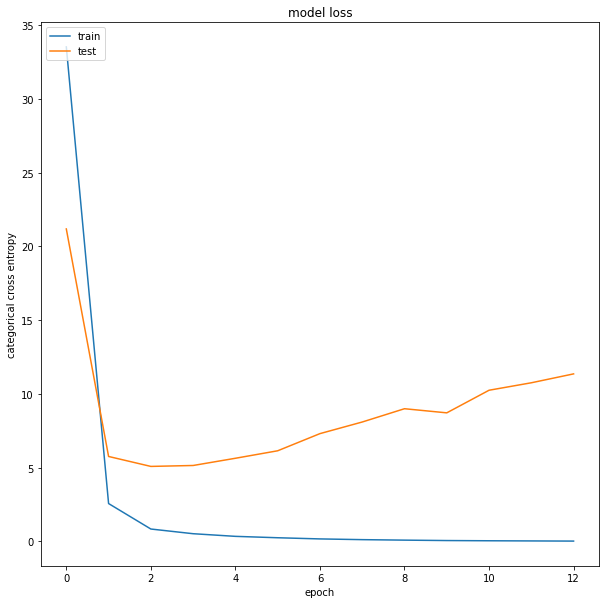

In [ ]:
####################
# display loss history
####################

import seaborn as sb

history = training_history

plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# # Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#Display confusion Matrix

Diagonal elemets of the confusion matrix:
           values
dutch         1.0
french        0.0
cantonese     0.0
amharic       0.0
farsi         0.0
bengali       0.0
arabic        2.0
english       4.0
bulgarian     0.0
Accuracy : 0.19444444444444445
Chance Accuracy would be 0.1111111111111111
Finished


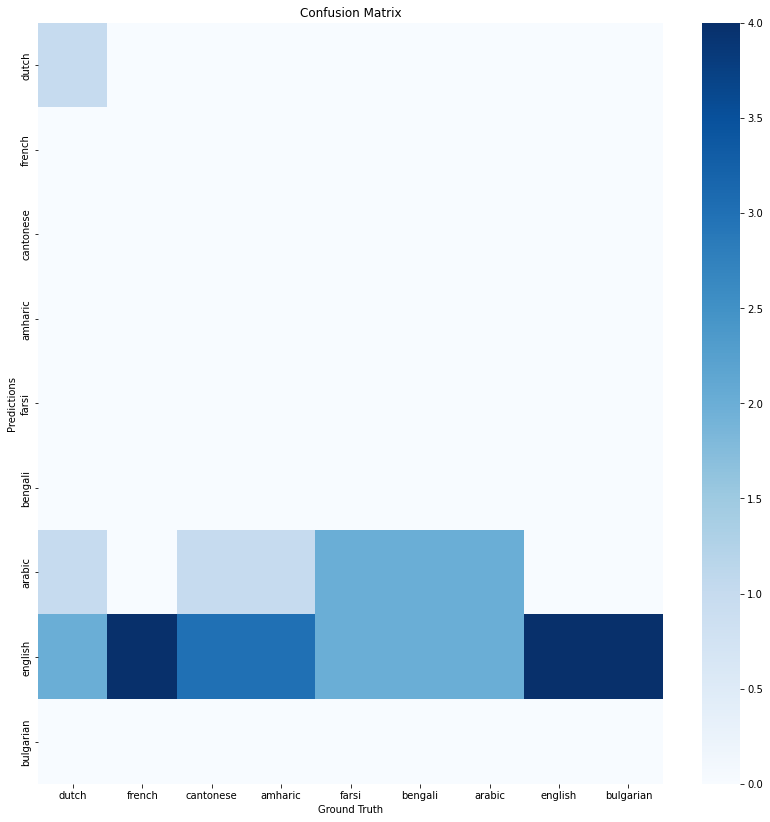

In [ ]:
####################
# display confusion matrix
####################

from sklearn.metrics import confusion_matrix

preds_df = pd.DataFrame({'GroundTruth': ground_truth_categorical, 'Predictions':predictions_categorical})
# print(preds_df)
num_categories = len(training_languages_dict)
confusion_matrix = np.zeros([num_categories,num_categories])
for index in range(len(predictions_categorical)):
  confusion_matrix[predictions_categorical[index], ground_truth_categorical[index]] += 1

plt.figure(figsize=(14,14))
tick_labels = list(training_languages_dict.keys())
ax = sb.heatmap(confusion_matrix, 
                xticklabels=tick_labels, 
                yticklabels=tick_labels, 
                annot=False, 
                fmt='', 
                cmap='Blues')

ax.set(title="Confusion Matrix",
      ylabel="Predictions",
      xlabel="Ground Truth",)
 
sb.set(font_scale=2) # set fontsize 2

cm_diag=[confusion_matrix[ind,ind] for ind in range(confusion_matrix.shape[0])]
cm_diag_df = pd.DataFrame({'values':cm_diag},index=tick_labels)

# Convert the whole dataframe as a string and display
# The scope of these changes made to
# pandas settings are local to with statement.
print("Diagonal elemets of the confusion matrix:")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(cm_diag_df)

print(f"Accuracy : {sum(cm_diag)/sum(sum(confusion_matrix))}")
print(f"Chance Accuracy would be {1./len(cm_diag)}")
print("Finished")